# Defining Distributed Areas of Interest

**Where we start:**
This notebook is the third part of the data analysis pipeline described in our [blog post][blog_post_link]. We assume that you already have an idea of what a reference image and fixation data from the Reference Image Mapper Enrichment looks like. If you don't, please check out the notebook ["Exploring Data from the Reference Image Mapper"][notebook_link].

To follow this notebook, you need to download multiple Reference Image Mapper Enrichements (e.g. from our [Demo Workspace][workspace_link]). The files of each Reference Image Mapper need to be located in an individual, unzipped folder, and those folders need to be placed together in one folder. This "super-folder", containing all other folders needs to be in the same directory from where this code is being executed. The name of this "super-folder" for our example is "reference_image_enrichments".

**IMPORTANT!** This notebook only works with Reference Image Mapper Enrichments that were computed on one continuous recording. In the context of the Museum Study, it will work either with the Downstairs OR with the Upstairs recording, but reference images from the two cannot be mixed together.


**Dependencies:**
[matplotlib][matplotlib_link], [OpenCV][opencv_link], [pandas][pandas_link], [numpy][numpy_link] and [pillow][pillow_link] are installed.


**What we do:**
We recursively load images and data from multiple Reference Image Mapper Enrichments. We combine the images in one plot, and combine the fixation data files in one large csv file. When combining the fixation data in one file, we add a column that defines the reference image these fixations belong to. In this example, one reference image is equal to one AOI.


**What we get:**
A csv file with the fixation data belonging to each of the Reference Image Mapper Enrichments in our "super-folder". The file includes one additional column indicating on which AOI/reference image the fixation occurred.

[workspace_link]: https://cloud.pupil-labs.com/workspace/78cddeee-772e-4e54-9963-1cc2f62825f9
[matplotlib_link]: https://matplotlib.org/ 
[opencv_link]: https://opencv.org/
[pandas_link]: https://pandas.pydata.org/
[pillow_link]: https://python-pillow.org/
[numpy_link]:https://numpy.org/

## Import Needed Libraries and Define Paths

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from PIL import Image

plt.rcParams.update({"font.size": 16})

# ACTION NEEDED: Define the folder with our data
path_to_folders = "./reference_image_enrichments/"

## Loading Data from Multiple Folders
For the [blog post][blog_post_link], we used the Reference Image Mapper Enrichements "Gary_Cain", "Adel Dauood 2", "Adel Dauood 3", "Adel Dauood 4", "Ingerlise Vikne", and "Gunlief Grube", all in the "walking" condition. 

To load the files iteratively, we will first define some helper functions.

In [2]:
def get_file_list(file_name, directory=path_to_folders):
    """
    returns a list of paths to all files of a given name in subfolders of the given directory
    """
    all_aoi_recordings = os.listdir(directory)
    return [f"{directory}{aoi}/{file_name}" for aoi in all_aoi_recordings]


# define a function that extracts the image name from the path
extract_name = lambda name: name.split("MAPPER_")[1].split("_csv")[0]


def load_csv_files(file_name):
    """
    recursively loads csv files and concatenates them in a long data frame
    """
    file_list = get_file_list(file_name)
    data = pd.DataFrame()

    for file_id, file in enumerate(file_list):

        df = pd.read_csv(file)
        df["AOI"] = file_id
        df["AOI_name"] = extract_name(file)

        data = pd.concat([data, df], ignore_index=True)

    return data

## Load and Display an Array of Areas of Interest
Now we start visualizing our AOIs. We don't have one single reference image, but multiple ones, where each reference image shows only one painting. We therefore create a figure with subplots and make each reference image a subplot within that figure.

The result is a grid of reference images, where each reference image is an AOI.

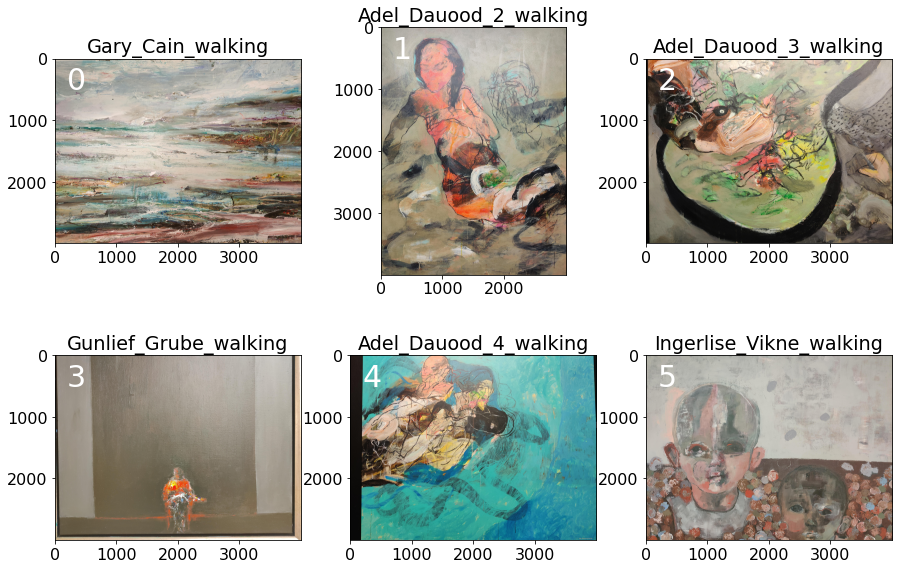

In [3]:
# Load images
images = get_file_list("reference_image.jpeg")

# Initialize list of AOI names
aoi_names = []

# create a plot for the images
fig_reference, ax_reference = plt.subplots(
    int(np.ceil(len(images) / 3)), 3, figsize=(15, 10)
)


def show_all_ref_images(images, axes):
    for ax, im, idx in zip(axes.flatten(), images, range(len(images))):
        reference_image = Image.open(im)
        ax.imshow(np.asarray(reference_image))
        name = extract_name(im)
        aoi_names.append(name)
        ax.set_title(name)
        ax.text(200, 500, idx, color="white", fontsize=30)


show_all_ref_images(images, ax_reference)

# Option: uncomment to save your visualisation
# fig_reference.savefig('./figures/reference_image_distributed.png', bbox_inches='tight', pad_inches = 0);

Have a look at the plot to see if it looks as expected - is there any image missing? Or is there one that you didn't expect to show up? If that's the case, then there might be a folder missing (or too many folders) in your "super-folder".

Also note how every AOI here seems to have the same dimensions in pixels. If you look at the recordings in our [Demo Workspace][workspace_link] you will see that they are actually quite different in size and format. This is something you need to keep in mind when working with the Reference Image Mapper - it only sees what the camera that took the reference image saw. 

With multiple reference images that had different sizes in real life, it makes sense to take notes of their actual dimensions and compare them to the metrics you will extract from the data later on. 

[workspace_link]: https://cloud.pupil-labs.com/workspace/78cddeee-772e-4e54-9963-1cc2f62825f9

## Filter All Fixations That Were on the Areas of Interest
The fixation data from the Reference Image Mapper Enrichment has one column that tells you if the fixation was inside our outside the reference image. 

Since in this case every reference image is equal to one AOI, you can interpret this column as "fixation detected inside the AOI". So we can use this column to filter all fixations that were made on each AOI. 

But watch out - this little trick won't work anymore if there is more than one AOI in one reference image or if there are any parts in the reference image that are not part of your AOI (in the context of a gallery, that could be walls, doors, or the floor).

In [4]:
# Loading fixation data
fixations = load_csv_files("fixations.csv")
# defining a list of recording id names
recordings = np.unique(fixations["recording id"])

# filter the fixation inside AOIs
fixations = fixations[fixations["fixation detected in reference image"]]
fixations.head()

,section id,recording id,fixation id,start timestamp [ns],end timestamp [ns],duration [ms],fixation detected in reference image,fixation x [px],fixation y [px],AOI,AOI_name
246,06b8dfbb-ffba-4dc9-bf95-f0dcf8889de3,71fadeee-ed00-48f1-863b-6bf16a62b095,254,1.636036e+18,1.636036e+18,124,True,509.0,2862.0,0,Gary_Cain_walking
247,06b8dfbb-ffba-4dc9-bf95-f0dcf8889de3,71fadeee-ed00-48f1-863b-6bf16a62b095,255,1.636036e+18,1.636036e+18,195,True,1285.0,2854.0,0,Gary_Cain_walking
320,06b8dfbb-ffba-4dc9-bf95-f0dcf8889de3,71fadeee-ed00-48f1-863b-6bf16a62b095,328,1.636036e+18,1.636036e+18,160,True,1891.0,1601.0,0,Gary_Cain_walking
321,06b8dfbb-ffba-4dc9-bf95-f0dcf8889de3,71fadeee-ed00-48f1-863b-6bf16a62b095,329,1.636036e+18,1.636036e+18,175,True,2362.0,1419.0,0,Gary_Cain_walking
322,06b8dfbb-ffba-4dc9-bf95-f0dcf8889de3,71fadeee-ed00-48f1-863b-6bf16a62b095,330,1.636036e+18,1.636036e+18,207,True,2463.0,1265.0,0,Gary_Cain_walking


## Overlay Fixations on Top of the Areas of Interest
Now, we can plot fixations on top of each AOI. We will color them by the identity of the AOI and scale the size of each AOI to the duration of the fixation.

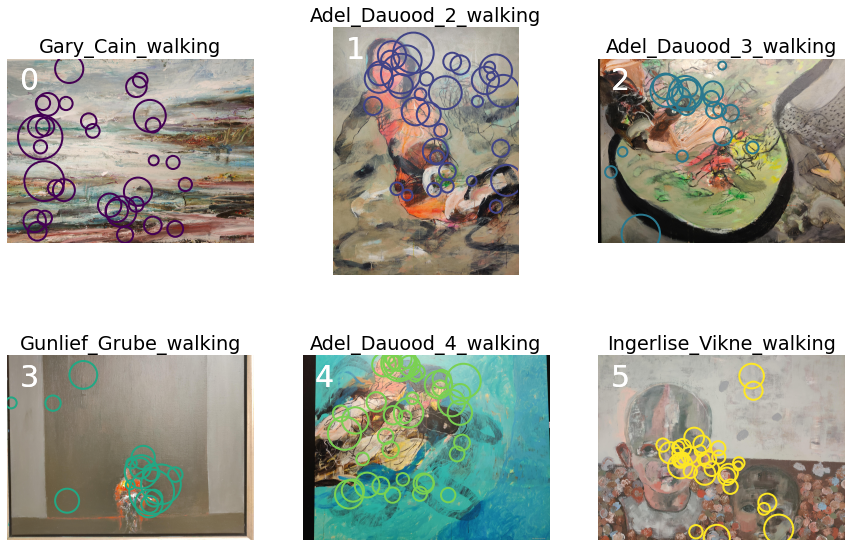

In [5]:
# define a color map
aoi_colors = matplotlib.cm.get_cmap("viridis")
n_colorsteps = len(images) - 1

# take one example recording for the visualization
example_recording = recordings[0]
example_fixations = fixations[fixations["recording id"] == example_recording]

# plot the reference images in order
fig_fixations, axs_fixations = plt.subplots(
    int(np.ceil(len(images) / 3)), 3, figsize=(15, 10)
)
show_all_ref_images(images, axs_fixations)

# plot fixations on top of the reference images
for ax, aoi in zip(axs_fixations.flatten(), images):
    aoi_fixations = example_fixations[
        example_fixations["AOI_name"] == extract_name(aoi)
    ]
    colors = [aoi_colors(x / n_colorsteps) for x in aoi_fixations["AOI"]]
    ax.text(200, 500, np.unique(aoi_fixations["AOI"])[0], color="white", fontsize=30)

    ax.scatter(
        aoi_fixations["fixation x [px]"],
        aoi_fixations["fixation y [px]"],
        edgecolors=colors,
        facecolors="none",
        linewidth=2,
        s=aoi_fixations["duration [ms]"],
    )
    ax.set_axis_off()

# Option: uncomment to save your visualisation
# fig_fixations.savefig('./figures/fixations_reference_image_distributed.png', bbox_inches='tight', pad_inches = 0);

And again, we've reached another checkpoint to see if all went well:

- Are there fixations on each of the AOIs? (If not, would it make sense that there are none for this particular AOI)?
- Do the fixations fall onto reasonable parts of the AOI or do they look completly off? 
- Do all fixations on one AOI have the same color?


## Save the Fixation Data with Areas of Interest
Finally, we can also save the fixation data file that indicates which AOI has been fixated.
You will need this file for the last step of the pipeline, where we look into gaze metrics.

In [6]:
fixations.to_csv("fixations_with_aois_distributed.csv")